## 1. A simulation exercise in regularization framework: sparsity in population coefficients

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
import random
random.seed(12092024)

In [3]:
def gen_data(n, p, regime="sparse"):
    # constants chosen to get R^2 of approximately .80
    if regime == "sparse":
        beta = ((1 / np.arange(1, p + 1)) ** 2) * 7
    elif regime == "dense":
        beta = np.sort(np.random.uniform(0.9,1,p))[::-1]

    def true_fn(x):
        return x @ beta

    X = np.random.uniform(-.5, .5, size=(n, p))
    gX = true_fn(X)
    y = gX + np.random.normal(0, 1, size=n)
    Xpop = np.random.uniform(-.5, .5, size=(100000, p))  # almost population limit
    gXpop = true_fn(Xpop)
    ypop = gXpop + np.random.normal(0, 1, size=100000)  # almost population limit
    return X, y, gX, Xpop, ypop, gXpop, beta

### Approximate sparse coefficients

We are going to simulate a data generating process which coefficients vector is sparse. A set of coefficients is said to be approximate sparse if it satisfies the following property:


\begin{equation*}

\beta_j \propto \frac{1}{j^2}, \quad \forall j=1,2,\dots,p

\end{equation*}

In other words, the predictive power relies in a small subset of the coefficients vector (the larger ones).

In [4]:
n = 100
p = 400
X, y, gX, Xpop, ypop, gXpop, betas = gen_data(n, p, regime="sparse")

We can plot the set of (sorted) coefficients' magnitude to visualize their behavior

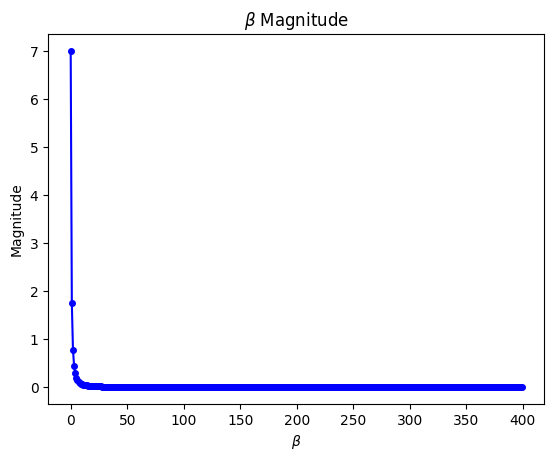

In [5]:
plt.figure()
plt.plot(range(len(betas)), abs(betas), color='b', marker = 'o', markersize = 4)
plt.xlabel(r'$\beta$')
plt.ylabel('Magnitude')
plt.title(r'$\beta$ Magnitude')
plt.show()

As you may already notice, we are woking in a high dimensional setting ($p>n$). Let's test the dimensional reduction capabilities of the regularization methods. We would like to select only features which provide the most predictive power.

Remember that the general regularization problem (in p-norm) is the following:

\begin{equation*}

\min_{\beta_j \in \beta} \sum_{i=1}^{n}(Y_i - \beta^{\prime}X_i)^2 + \lambda\lVert \beta \lVert_p

\end{equation*}

where

\begin{equation*}

\lVert \beta \lVert_p = \left(\sum_{\beta_j \in \beta}\left|{\beta_{j}}^{p}\right|\right) ^{1/p}

\end{equation*}

When $p=1$, it is a Lasso (or L1) regularization . When $p=2$, it is a Ridge (or L2) regularization. We will explore the latter it in the next sessions

So, we fit a Lasso regularization. To tune the penalization parameter $\lambda$, we perform a cross-validation Lasso regression with $k=5$ folds.

In [6]:
model_l1 = LassoCV(fit_intercept= False, cv=5).fit(X,y)
betas_l1 = model_l1.coef_
model_l1.alpha_

np.float64(0.06955018847618888)

If you want to do it from scratch, you can proceed as follows

In [7]:
# Lasso cross validation from scratch (as stated in lecture 3)

upper_bound = 1
niter = 1000
alpha = np.arange(0,upper_bound,upper_bound/niter)
kf = KFold(n_splits=5)

avg_mspe = []

for i in alpha:

    fold_pe = []

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = Lasso(alpha=i).fit(X_train,y_train)

        predict = model.predict(X_test)

        pe = np.sum((y_test-predict)**2)

        fold_pe.append(pe)

    avg_mspe.append(np.mean(np.array(fold_pe)))

chosen_alpha = alpha[np.where(np.array(avg_mspe)==np.min(np.array(avg_mspe)))]

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results

Let's see how the RMSE across folds behaves as lambda changes

Text(0, 0.5, 'RMSE across folds')

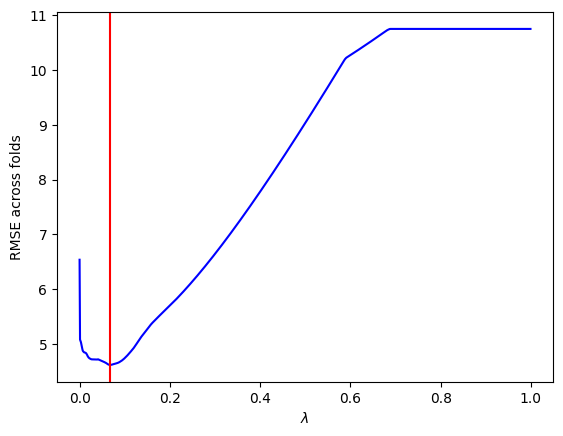

In [8]:
plt.plot(alpha,np.array(avg_mspe)**(1/2), color = 'blue')
plt.axvline(x = chosen_alpha, color = 'red')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'RMSE across folds')

Finally let's plot the estimated coefficients vs the population parameters

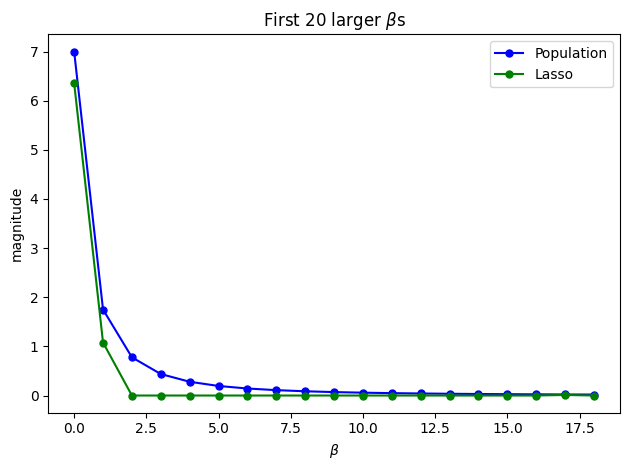

In [9]:
plt.subplot()
plt.title(r'First 20 larger $\beta$s')
plt.plot(range(len(betas[:19])), abs(betas[:19]), color = 'blue', marker = 'o', ms = 5)
plt.plot(range(len(betas_l1[:19])), abs(betas_l1[:19]),  color = 'green', marker = 'o', ms = 5)
plt.xlabel(r'$\beta$')
plt.ylabel(r'magnitude')
plt.legend(('Population','Lasso','Ridge'))
plt.tight_layout()

The main conclusion of this exercise is that Lasso regularization fits scenearios of approximate sparse coefficients because it select a small subset with high predictive power. The linear predictor provided by Lasso may not be the BLP, but works well under high dimensionality.

## 2. A Simple Case Study using Wage Data from 2015

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import patsy
import warnings
warnings.simplefilter('ignore')
np.random.seed(1234)

### Data

We consider data from the U.S. March Supplement of the Current Population Survey (CPS) in 2015.
The preproccessed sample consists of $5150$ never-married individuals.

In [11]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/wage2015_subsample_inference.csv"
data = pd.read_csv(file)
data.describe()

,wage,lwage,sex,shs,hsg,scl,clg,ad,mw,so,we,ne,exp1,exp2,exp3,exp4,occ,occ2,ind,ind2
count,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000,5150.000000
mean,23.410410,2.970787,0.444466,0.023301,0.243883,0.278058,0.317670,0.137087,0.259612,0.296505,0.216117,0.227767,13.760583,3.018925,8.235867,25.118038,5310.737476,11.670874,6629.154951,13.316893
std,21.003016,0.570385,0.496955,0.150872,0.429465,0.448086,0.465616,0.343973,0.438464,0.456761,0.411635,0.419432,10.609465,4.000904,14.488962,53.530225,11874.356080,6.966684,5333.443992,5.701019
min,3.021978,1.105912,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,370.000000,2.000000
25%,13.461538,2.599837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.250000,0.125000,0.062500,1740.000000,5.000000,4880.000000,9.000000
50%,19.230769,2.956512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,4040.000000,13.000000,7370.000000,14.000000
75%,27.777778,3.324236,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,21.000000,4.410000,9.261000,19.448100,5610.000000,17.000000,8190.000000,18.000000
max,528.845673,6.270697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,47.000000,22.090000,103.823000,487.968100,100000.000000,22.000000,100000.000000,22.000000


In [12]:
y = np.log(data['wage']).values
Z = data.drop(['wage', 'lwage'], axis=1)
Z.columns

Index(['sex', 'shs', 'hsg', 'scl', 'clg', 'ad', 'mw', 'so', 'we', 'ne', 'exp1',
       'exp2', 'exp3', 'exp4', 'occ', 'occ2', 'ind', 'ind2'],
      dtype='object')

The following figure shows the weekly wage distribution from the US survey data.

(0.0, 3000.0)

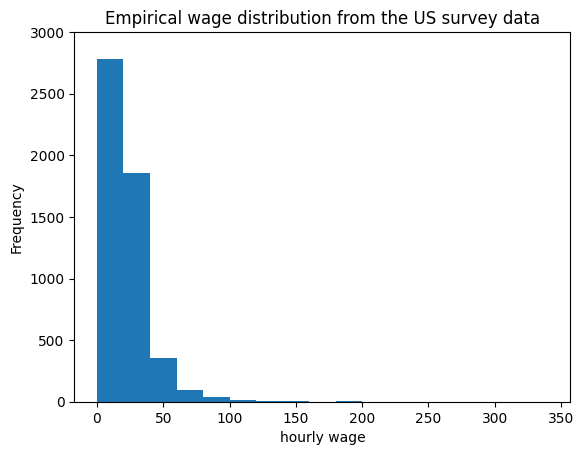

In [13]:
plt.hist(data.wage, bins=np.arange(0, 350, 20))
plt.xlabel('hourly wage')
plt.ylabel('Frequency')
plt.title('Empirical wage distribution from the US survey data')
plt.ylim((0, 3000))

Wages show a high degree of skewness. Hence, wages are transformed in almost all studies by the logarithm.

Due to the skewness of the data, we are considering log wages which leads to the following regression model

$$\log(\operatorname{wage}) = g(Z) + \epsilon.$$

In this notebook, we will evaluate *linear* prediction rules. In later notebooks, we will also utilize nonlinear prediction methods. In linear models, we estimate the prediction rule of the form

$$\hat g(Z) = \hat \beta'X.$$

Again, we generate $X$ in three ways:

1. Basic Model:   $X$ consists of a set of raw regressors (e.g. gender, experience, education indicators, regional indicators).


2. Flexible Model:  $X$ consists of all raw regressors from the basic model plus occupation and industry indicators, transformations (e.g., $\operatorname{exp}^2$ and $\operatorname{exp}^3$) and additional two-way interactions.

To evaluate the out-of-sample performance, we split the data first.

The basic model consists of $51$ regressors, and the flexible model has $246$ regressors. Let us fit our models to the training sample using the two different model specifications. We are starting by running a simple ols regression and computing the $R^2$ on the test sample.

### Low dimensional specification (basic)

In [14]:
Zbase = patsy.dmatrix('0 + sex + exp1 + shs + hsg+ scl + clg + mw + so + we + C(occ2) + C(ind2)',
                      Z, return_type='dataframe').values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Zbase, y, test_size=0.25, random_state=123)

In [16]:
lr_base = LinearRegression().fit(X_train, y_train)

Let's calculate R-squared on the test set

In [17]:
r2_base = 1 - np.mean((y_test - lr_base.predict(X_test))**2) / np.var(y_test)
print(f'{r2_base:.4f}')

0.2853


Since out of sample performance can be vary for different train-test splits, it is more stable to look at average performance across multiple splits, using K-fold cross validation.

In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LinearRegression(), Zbase, y, scoring='r2', cv=cv)
print(f'{np.mean(rsquares):.4f}')

0.2953


### High-dimensional specification (flexible)

We repeat the same procedure for the flexible model.

In [19]:
Zflex = patsy.dmatrix('0 + sex + (exp1+exp2+exp3+exp4)*(shs+hsg+scl+clg+C(occ2)+C(ind2)+mw+so+we)',
                      Z, return_type='dataframe').values

In [20]:
Zflex.shape

(5150, 246)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(Zflex, y, test_size=0.25, random_state=123)

In [22]:
lr_flex = LinearRegression().fit(X_train, y_train)

In [23]:
print('Flexible model R^2 (OLS): ', f'{r2_score(y_test, lr_flex.predict(X_test)):.4f}')

Flexible model R^2 (OLS):  0.2384


### Penalized regression: Lasso (flexible model)

We observe that ols regression works better for the basic model with smaller $p/n$ ratio. We proceed by running a Lasso regression for the flexible model, tuned via cross-validation.

To properly penalize the coefficients, we must standarize the data, so each regressor is symmetrically penalized 

In [24]:
from sklearn.preprocessing import StandardScaler
Zflex = StandardScaler().fit_transform(Zflex)

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
rsquares = cross_val_score(LassoCV(cv=cv), Zflex, y, scoring='r2', cv=cv, n_jobs=-1)
print('Flexible model R^2 (Lasso): ', f'{np.mean(rsquares):.4f}')

Flexible model R^2 (Lasso):  0.2959


Now we can plug in the theoretical $\lambda$. To do that we need to use HDM package for python

In [ ]:
# !git clone https://github.com/maxhuppertz/hdmpy.git
# !pip install multiprocess

In [27]:
import hdmpy
from sklearn.base import BaseEstimator


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return X @ np.array(self.rlasso_.est['beta']).flatten() + self.rlasso_.est['intercept'].values

In [35]:
Rlasso = RLasso()
Rlasso.fit(X_train, y_train)
Rlasso.rlasso_.est['lambda0']

np.float64(554.9834692716778)

In [43]:
Rlasso.predict(X_test)
Rlasso_MSE = np.mean((Rlasso.predict(X_test)-y_test)**2)
Rlasso_r2 = 1-(Rlasso_MSE/np.var(y_test))
Rlasso_r2

np.float64(0.26677790020630554)

In sum, Lasso provides a better out of sample predictive accuracy in the flexible model in a high dimensional setting,